In [134]:
%load_ext autoreload
%autoreload 2

from itertools import product
import os

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.multivariate_normal import MultivariateNormal
import torchvision
import cv2
from sklearn import mixture

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from neuode.interface.struct import *
import neuode.util.logging as logging
from neuode.dynamics.composite import build_dmap, build_dyn
import neuode.model.vae as model_vae

logger = logging.logger

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
print('blah')

blah


In [4]:
DPATH = '~/Documents/dataset'
BATCH_TRAIN_SIZE = 64
DIGIT = 0
C_AUGMENT = 0

class MNISTDigit(torch.utils.data.Dataset):
    
    def __init__(self, mnist, digit, augment):
        self.mnist = mnist
        self.digit = digit
        self.augment = augment
        
        self.idxs = []
        for i, (_, label) in enumerate(self.mnist):
            if label == self.digit:
                self.idxs.append(i)
                
    def __len__(self):
        return len(self.idxs)
        
    def __getitem__(self, idx):
        img, label = self.mnist[self.idxs[idx]]
        return self.augment_image(img), label
    
#     def __iter__(self):
#         for img, label in self.mnist:
#             if label == self.digit:
#                 yield self.augment_image(img), label

    def augment_image(self, img):
        channels, height, width = img.shape
        img_aug = torch.zeros(self.augment, height, width)
        return torch.cat([img, img_aug], 0)
        

mnist = torchvision.datasets.MNIST(DPATH, train=True, download=True,
        transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize((32, 32)),
            torchvision.transforms.ToTensor(),
            # torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]))
dmnist = []
for d in range(10):
    print('loading digit', d)
    dmnist.append(MNISTDigit(mnist, d, C_AUGMENT))

train_loader = torch.utils.data.DataLoader(dmnist[DIGIT], batch_size=BATCH_TRAIN_SIZE, shuffle=True)
mnist_loader = torch.utils.data.DataLoader(mnist, batch_size=BATCH_TRAIN_SIZE, shuffle=True)

loading digit 0
loading digit 1
loading digit 2
loading digit 3
loading digit 4
loading digit 5
loading digit 6
loading digit 7
loading digit 8
loading digit 9


Text(0.5, 1.0, 'digit= 0')

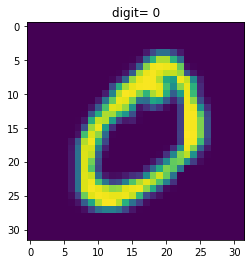

In [10]:
# principle digit (mean)
ideal_digit, label = dmnist[0][0]
plt.imshow(ideal_digit[0, ...])
plt.title('digit= %d'%label)

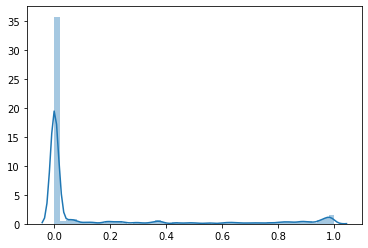

In [11]:
sns.distplot(ideal_digit.flatten())

In [68]:
# build model
cfn_specs = [
    ConvSpec(C_AUGMENT+1, C_AUGMENT+3, kernel_size=5, stride=1, padding=2, 
             act_fn=ActivationFn.RELU),
    ConvSpec(C_AUGMENT+3, C_AUGMENT+3, kernel_size=5, stride=1, padding=2, 
             act_fn=ActivationFn.RELU),
    ConvSpec(C_AUGMENT+3, C_AUGMENT+1, kernel_size=5, stride=1, padding=2,
             act_fn=ActivationFn.NONE),
]
ode_spec = ODEBlockSpec(use_adjoint=True)
cfn = conv.FullConvDMap(cfn_specs)
net = odeblock.ODEBlock(cfn, ode_spec)

In [39]:
# build time-dependent model
cfn_specs_t = [
    ConvSpec(C_AUGMENT+1, C_AUGMENT+3, kernel_size=5, stride=1, padding=2, 
             act_fn=ActivationFn.RELU, use_time=True),
    ConvSpec(C_AUGMENT+3, C_AUGMENT+3, kernel_size=5, stride=1, padding=2, 
             act_fn=ActivationFn.RELU, use_time=True),
    ConvSpec(C_AUGMENT+3, C_AUGMENT+1, kernel_size=5, stride=1, padding=2,
             act_fn=ActivationFn.NONE, use_time=True),
]
ode_spec_t = ODEBlockSpec(use_adjoint=True)
cfn_t = conv.FullConvDMap(cfn_specs_t)
net_t = odeblock.ODEBlock(cfn_t, ode_spec_t)

In [75]:
# train
def train(net):
    lr, momentum = 0.01, 0.9
    net.train()
    for epoch in range(20):
        criterion = nn.MSELoss()
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
        total = len(train_loader)
        for batch_idx, (data, _) in enumerate(train_loader):
            optimizer.zero_grad()
            pred = net(data)
            loss = criterion(pred[:, 0, ...], ideal_digit.repeat(len(data), 1, 1, 1)[:, 0, ...])
            loss.backward()
            optimizer.step()
            if batch_idx%1 == 0 or batch_idx == total-1:
                print('Epoch %3d [%4d/%4d (%2d%%)]: loss= %f'%(
                    epoch, batch_idx, total, int(100 * batch_idx / total), loss.item()))
            if batch_idx%5 == 0:
                plot_check(net, 10)
                plt.show()

Epoch   0 [   0/  93 ( 0%)]: loss= 0.354913


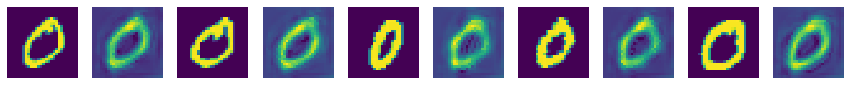

Epoch   0 [   1/  93 ( 1%)]: loss= 0.365679
Epoch   0 [   2/  93 ( 2%)]: loss= 0.341963
Epoch   0 [   3/  93 ( 3%)]: loss= 0.349500
Epoch   0 [   4/  93 ( 4%)]: loss= 0.373085
Epoch   0 [   5/  93 ( 5%)]: loss= 0.346547


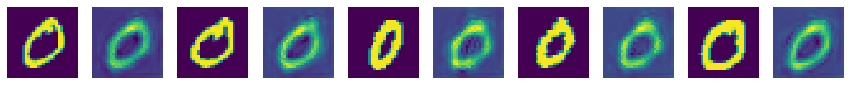

Epoch   0 [   6/  93 ( 6%)]: loss= 0.341260
Epoch   0 [   7/  93 ( 7%)]: loss= 0.348714
Epoch   0 [   8/  93 ( 8%)]: loss= 0.335692
Epoch   0 [   9/  93 ( 9%)]: loss= 0.345897
Epoch   0 [  10/  93 (10%)]: loss= 0.354799


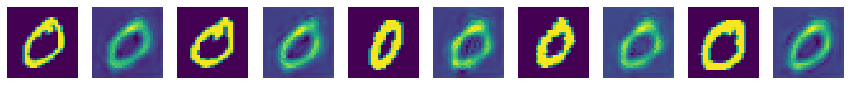

Epoch   0 [  11/  93 (11%)]: loss= 0.362120
Epoch   0 [  12/  93 (12%)]: loss= 0.326033
Epoch   0 [  13/  93 (13%)]: loss= 0.342977
Epoch   0 [  14/  93 (15%)]: loss= 0.401823
Epoch   0 [  15/  93 (16%)]: loss= 0.394216


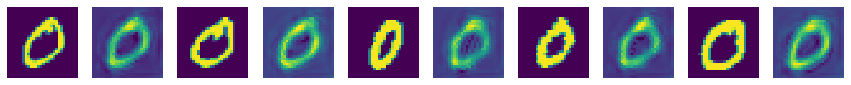

Epoch   0 [  16/  93 (17%)]: loss= 0.334536
Epoch   0 [  17/  93 (18%)]: loss= 0.443955
Epoch   0 [  18/  93 (19%)]: loss= 0.367023
Epoch   0 [  19/  93 (20%)]: loss= 0.403810
Epoch   0 [  20/  93 (21%)]: loss= 0.334270


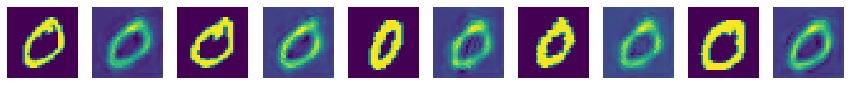

Epoch   0 [  21/  93 (22%)]: loss= 0.379021
Epoch   0 [  22/  93 (23%)]: loss= 0.383704
Epoch   0 [  23/  93 (24%)]: loss= 0.393447
Epoch   0 [  24/  93 (25%)]: loss= 0.417514
Epoch   0 [  25/  93 (26%)]: loss= 0.353889


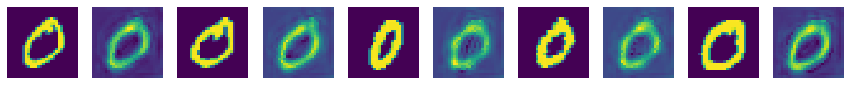

Epoch   0 [  26/  93 (27%)]: loss= 0.404253
Epoch   0 [  27/  93 (29%)]: loss= 0.353565
Epoch   0 [  28/  93 (30%)]: loss= 0.401143
Epoch   0 [  29/  93 (31%)]: loss= 0.314248
Epoch   0 [  30/  93 (32%)]: loss= 0.342581


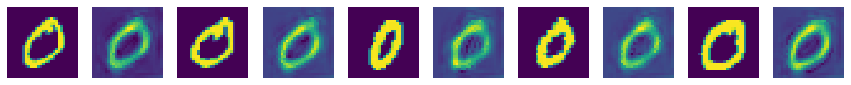

Epoch   0 [  31/  93 (33%)]: loss= 0.340053
Epoch   0 [  32/  93 (34%)]: loss= 0.332054
Epoch   0 [  33/  93 (35%)]: loss= 0.298541
Epoch   0 [  34/  93 (36%)]: loss= 0.313066
Epoch   0 [  35/  93 (37%)]: loss= 0.301374


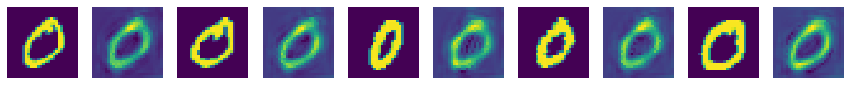

Epoch   0 [  36/  93 (38%)]: loss= 0.295603
Epoch   0 [  37/  93 (39%)]: loss= 0.308495
Epoch   0 [  38/  93 (40%)]: loss= 0.281424
Epoch   0 [  39/  93 (41%)]: loss= 0.290306
Epoch   0 [  40/  93 (43%)]: loss= 0.311463


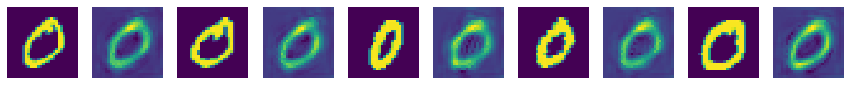

Epoch   0 [  41/  93 (44%)]: loss= 0.272256
Epoch   0 [  42/  93 (45%)]: loss= 0.262143
Epoch   0 [  43/  93 (46%)]: loss= 0.296436
Epoch   0 [  44/  93 (47%)]: loss= 0.295851
Epoch   0 [  45/  93 (48%)]: loss= 0.283974


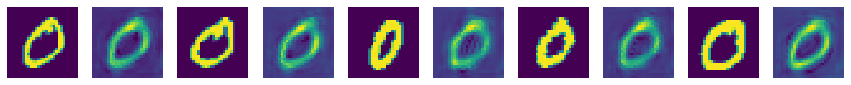

Epoch   0 [  46/  93 (49%)]: loss= 0.308395
Epoch   0 [  47/  93 (50%)]: loss= 0.363457
Epoch   0 [  48/  93 (51%)]: loss= 0.440012
Epoch   0 [  49/  93 (52%)]: loss= 0.334618
Epoch   0 [  50/  93 (53%)]: loss= 0.444102


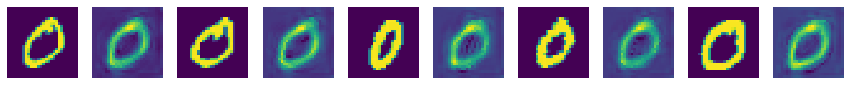

Epoch   0 [  51/  93 (54%)]: loss= 0.324293
Epoch   0 [  52/  93 (55%)]: loss= 0.396106
Epoch   0 [  53/  93 (56%)]: loss= 0.282061
Epoch   0 [  54/  93 (58%)]: loss= 0.444219
Epoch   0 [  55/  93 (59%)]: loss= 0.323379


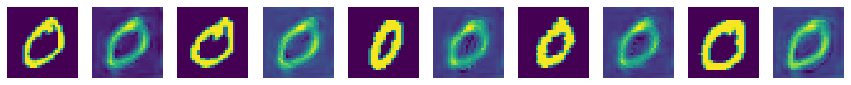

Epoch   0 [  56/  93 (60%)]: loss= 0.418298
Epoch   0 [  57/  93 (61%)]: loss= 0.366667
Epoch   0 [  58/  93 (62%)]: loss= 0.389963
Epoch   0 [  59/  93 (63%)]: loss= 0.390472
Epoch   0 [  60/  93 (64%)]: loss= 0.346289


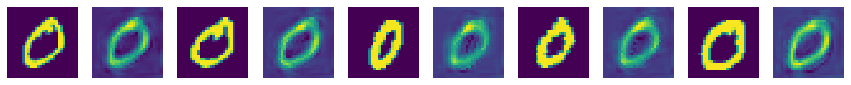

Epoch   0 [  61/  93 (65%)]: loss= 0.401607
Epoch   0 [  62/  93 (66%)]: loss= 0.351159
Epoch   0 [  63/  93 (67%)]: loss= 0.367452
Epoch   0 [  64/  93 (68%)]: loss= 0.356271
Epoch   0 [  65/  93 (69%)]: loss= 0.330641


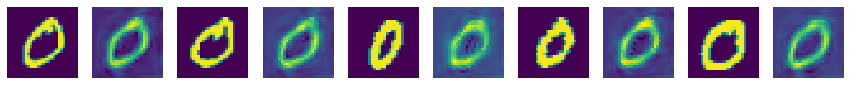

Epoch   0 [  66/  93 (70%)]: loss= 0.357136
Epoch   0 [  67/  93 (72%)]: loss= 0.309579
Epoch   0 [  68/  93 (73%)]: loss= 0.350494
Epoch   0 [  69/  93 (74%)]: loss= 0.314875
Epoch   0 [  70/  93 (75%)]: loss= 0.314042


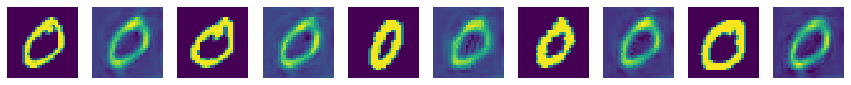

Epoch   0 [  71/  93 (76%)]: loss= 0.315419
Epoch   0 [  72/  93 (77%)]: loss= 0.352727
Epoch   0 [  73/  93 (78%)]: loss= 0.348842
Epoch   0 [  74/  93 (79%)]: loss= 0.357774
Epoch   0 [  75/  93 (80%)]: loss= 0.339434


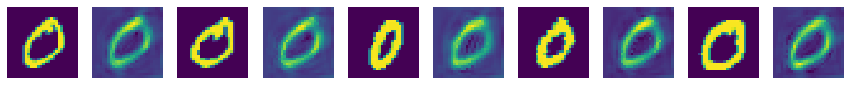

Epoch   0 [  76/  93 (81%)]: loss= 0.359783
Epoch   0 [  77/  93 (82%)]: loss= 0.296429
Epoch   0 [  78/  93 (83%)]: loss= 0.329722
Epoch   0 [  79/  93 (84%)]: loss= 0.316212
Epoch   0 [  80/  93 (86%)]: loss= 0.304472


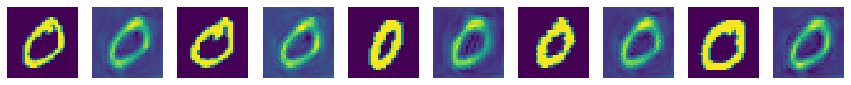

Epoch   0 [  81/  93 (87%)]: loss= 0.321754
Epoch   0 [  82/  93 (88%)]: loss= 0.317284
Epoch   0 [  83/  93 (89%)]: loss= 0.338758
Epoch   0 [  84/  93 (90%)]: loss= 0.380131
Epoch   0 [  85/  93 (91%)]: loss= 0.360310


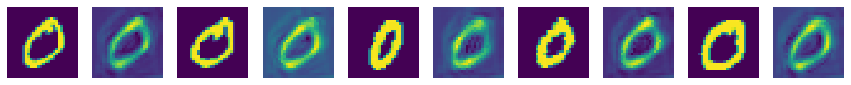

Epoch   0 [  86/  93 (92%)]: loss= 0.364645
Epoch   0 [  87/  93 (93%)]: loss= 0.350298
Epoch   0 [  88/  93 (94%)]: loss= 0.358240
Epoch   0 [  89/  93 (95%)]: loss= 0.337062
Epoch   0 [  90/  93 (96%)]: loss= 0.334344


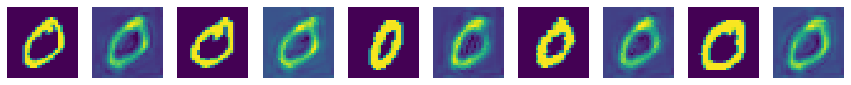

Epoch   0 [  91/  93 (97%)]: loss= 0.365397
Epoch   0 [  92/  93 (98%)]: loss= 0.328221
Epoch   1 [   0/  93 ( 0%)]: loss= 0.360497


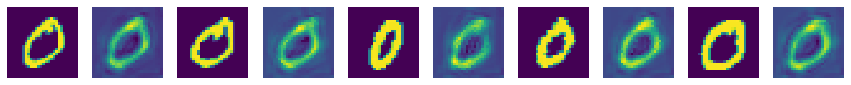

Epoch   1 [   1/  93 ( 1%)]: loss= 0.315595
Epoch   1 [   2/  93 ( 2%)]: loss= 0.410013
Epoch   1 [   3/  93 ( 3%)]: loss= 0.388062
Epoch   1 [   4/  93 ( 4%)]: loss= 0.347983
Epoch   1 [   5/  93 ( 5%)]: loss= 0.377266


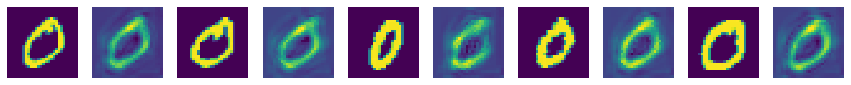

Epoch   1 [   6/  93 ( 6%)]: loss= 0.369111
Epoch   1 [   7/  93 ( 7%)]: loss= 0.342388
Epoch   1 [   8/  93 ( 8%)]: loss= 0.324026
Epoch   1 [   9/  93 ( 9%)]: loss= 0.384346
Epoch   1 [  10/  93 (10%)]: loss= 0.331828


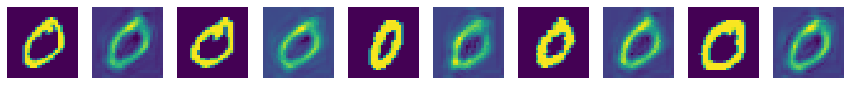

Epoch   1 [  11/  93 (11%)]: loss= 0.382467
Epoch   1 [  12/  93 (12%)]: loss= 0.483387
Epoch   1 [  13/  93 (13%)]: loss= 0.373280
Epoch   1 [  14/  93 (15%)]: loss= 0.473115
Epoch   1 [  15/  93 (16%)]: loss= 0.401027


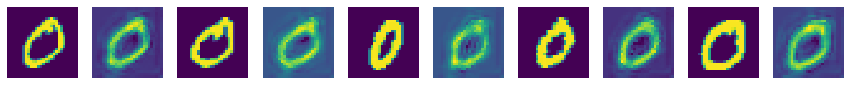

Epoch   1 [  16/  93 (17%)]: loss= 0.384891
Epoch   1 [  17/  93 (18%)]: loss= 0.410808
Epoch   1 [  18/  93 (19%)]: loss= 0.344456
Epoch   1 [  19/  93 (20%)]: loss= 0.431440
Epoch   1 [  20/  93 (21%)]: loss= 0.323926


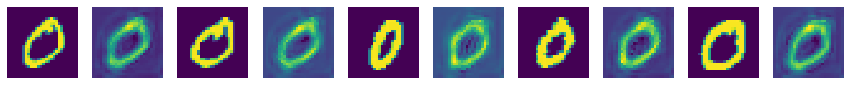

Epoch   1 [  21/  93 (22%)]: loss= 0.363286
Epoch   1 [  22/  93 (23%)]: loss= 0.365832
Epoch   1 [  23/  93 (24%)]: loss= 0.390572
Epoch   1 [  24/  93 (25%)]: loss= 0.370063
Epoch   1 [  25/  93 (26%)]: loss= 0.347720


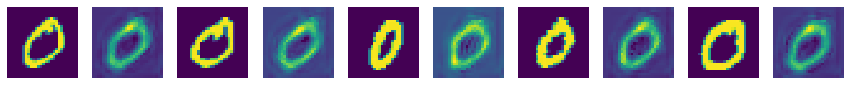

Epoch   1 [  26/  93 (27%)]: loss= 0.342824
Epoch   1 [  27/  93 (29%)]: loss= 0.314165
Epoch   1 [  28/  93 (30%)]: loss= 0.328605
Epoch   1 [  29/  93 (31%)]: loss= 0.313500
Epoch   1 [  30/  93 (32%)]: loss= 0.316046


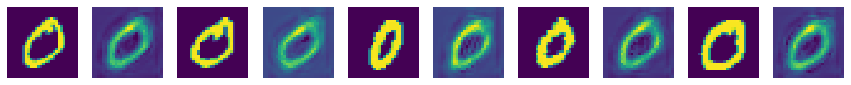

Epoch   1 [  31/  93 (33%)]: loss= 0.313971
Epoch   1 [  32/  93 (34%)]: loss= 0.308734
Epoch   1 [  33/  93 (35%)]: loss= 0.287997
Epoch   1 [  34/  93 (36%)]: loss= 0.298412
Epoch   1 [  35/  93 (37%)]: loss= 0.290130


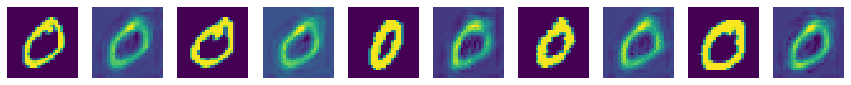

Epoch   1 [  36/  93 (38%)]: loss= 0.303861
Epoch   1 [  37/  93 (39%)]: loss= 0.297556
Epoch   1 [  38/  93 (40%)]: loss= 0.312582
Epoch   1 [  39/  93 (41%)]: loss= 0.292722
Epoch   1 [  40/  93 (43%)]: loss= 0.264933


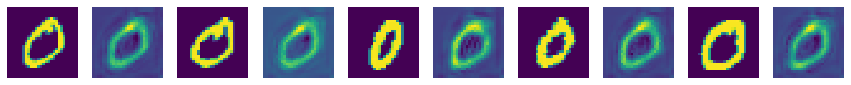

Epoch   1 [  41/  93 (44%)]: loss= 0.265103
Epoch   1 [  42/  93 (45%)]: loss= 0.275090
Epoch   1 [  43/  93 (46%)]: loss= 0.298055
Epoch   1 [  44/  93 (47%)]: loss= 0.269462
Epoch   1 [  45/  93 (48%)]: loss= 0.246162


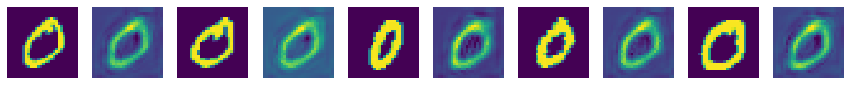

Epoch   1 [  46/  93 (49%)]: loss= 0.270103
Epoch   1 [  47/  93 (50%)]: loss= 0.281556
Epoch   1 [  48/  93 (51%)]: loss= 0.276986
Epoch   1 [  49/  93 (52%)]: loss= 0.280530
Epoch   1 [  50/  93 (53%)]: loss= 0.339129


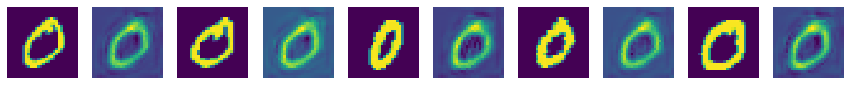

Epoch   1 [  51/  93 (54%)]: loss= 0.341766
Epoch   1 [  52/  93 (55%)]: loss= 0.437552
Epoch   1 [  53/  93 (56%)]: loss= 0.428420
Epoch   1 [  54/  93 (58%)]: loss= 0.544449
Epoch   1 [  55/  93 (59%)]: loss= 0.438595


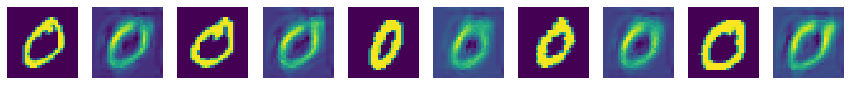

Epoch   1 [  56/  93 (60%)]: loss= 0.567380
Epoch   1 [  57/  93 (61%)]: loss= 0.411592
Epoch   1 [  58/  93 (62%)]: loss= 0.418045
Epoch   1 [  59/  93 (63%)]: loss= 0.512292
Epoch   1 [  60/  93 (64%)]: loss= 0.940910


AssertionError: max_num_steps exceeded (1000>=1000)

In [86]:
train(net)

In [ ]:
train(net_t)

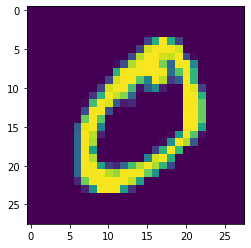

In [110]:
plt.imshow(ideal_digit[0])

In [54]:
def plot_check(NET, NX):
    with torch.no_grad():
        # generate initial point and find trajectory
        OFFSET = 0
        L, R, NT = 0.0, 1.0, 2
        x0 = torch.stack([dmnist[i][0] for i in range(OFFSET, OFFSET+NX)])
        traj = NET.trajectory(x0, L, R, NT).numpy()
        
#     print(np.mean((traj[-1, :, 0, ...] - ideal_digit.repeat(10, 1, 1, 1)[:, 0, ...].numpy())**2))

    NC, SZ = 5, 1.5
    NR = (NX - 1) // (2*NC) + 1
    fig, axes = plt.subplots(nrows=NR, ncols=2*NC, figsize=(2*NC*SZ, NR*SZ))
    axes = axes.flatten()
    axes0 = axes[::2]
    axes1 = axes[1::2]
    for i, ax0, ax1 in zip(range(NX), axes0, axes1):
        logging.render_video(traj[:, i, ...], path='/home/mixs/Documents/research/neuode/dump/digit_%d.mp4'%i)
        ax0.imshow(traj[0, i, 0, ...])
        ax1.imshow(traj[-1, i, 0, ...])
    for ax in axes:
        ax.axis('off')

In [ ]:
plot_check(net, 10)

In [137]:
net.spec.max_num_step = 2000

## MNIST VAE

In [23]:
MODEL_DIR = '/home/mixs/Documents/research/neuode/dump/model'

def get_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print('created directory', path)
    return path

get_dir(MODEL_DIR)

'/home/mixs/Documents/research/neuode/dump/model'

In [9]:
vae_64 = model_vae.generate_vae(mnist_loader, z_dim=64, nepoch=5, lr=0.1, verbose=True)

Epoch   0 [   0/ 938 ( 0%)]: loss= 8.071019
Epoch   0 [ 100/ 938 (10%)]: loss= 2.272924
Epoch   0 [ 200/ 938 (21%)]: loss= 2.005941
Epoch   0 [ 300/ 938 (31%)]: loss= 1.949553
Epoch   0 [ 400/ 938 (42%)]: loss= 1.829637
Epoch   0 [ 500/ 938 (53%)]: loss= 1.715810
Epoch   0 [ 600/ 938 (63%)]: loss= 1.707373
Epoch   0 [ 700/ 938 (74%)]: loss= 1.633535
Epoch   0 [ 800/ 938 (85%)]: loss= 1.577698
Epoch   0 [ 900/ 938 (95%)]: loss= 1.561122
Epoch   0 [ 937/ 938 (99%)]: loss= 1.631978
Epoch   1 [   0/ 938 ( 0%)]: loss= 1.568402
Epoch   1 [ 100/ 938 (10%)]: loss= 1.653899
Epoch   1 [ 200/ 938 (21%)]: loss= 1.614562
Epoch   1 [ 300/ 938 (31%)]: loss= 1.554567
Epoch   1 [ 400/ 938 (42%)]: loss= 1.703145
Epoch   1 [ 500/ 938 (53%)]: loss= 1.578452
Epoch   1 [ 600/ 938 (63%)]: loss= 1.560894
Epoch   1 [ 700/ 938 (74%)]: loss= 1.529358
Epoch   1 [ 800/ 938 (85%)]: loss= 1.534421
Epoch   1 [ 900/ 938 (95%)]: loss= 1.669329
Epoch   1 [ 937/ 938 (99%)]: loss= 1.588265
Epoch   2 [   0/ 938 ( 0%)]: los

In [24]:
IS_SAVE = False
p = os.path.join(MODEL_DIR, 'mnist_vae_64.pth')

if IS_SAVE:
    model_vae.save_vae(vae_64, p)
else:
    vae_64 = model_vae.build_vae(model_vae.build_spec_from_loader(mnist_loader, 64), p)

torch.Size([64, 1, 32, 32]) tensor([9, 7, 7, 2, 1, 6, 6, 2, 0, 0, 2, 6, 6, 2, 1, 1, 2, 4, 7, 6, 9, 7, 6, 0,
        9, 9, 2, 4, 7, 2, 8, 1, 2, 7, 9, 8, 8, 8, 8, 9, 6, 7, 1, 6, 7, 5, 7, 5,
        0, 3, 5, 0, 6, 4, 1, 1, 6, 0, 2, 9, 3, 0, 5, 2])


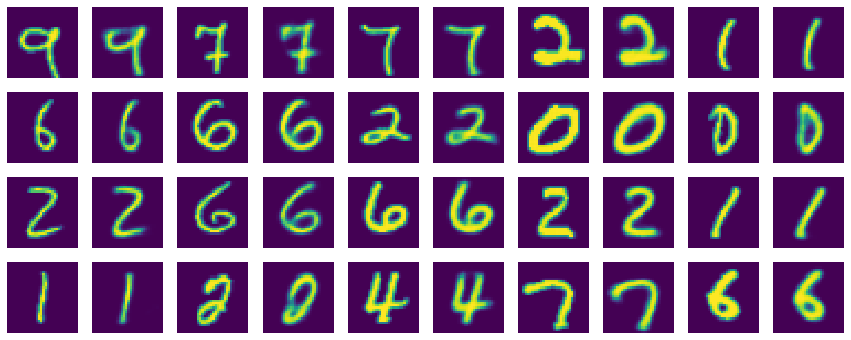

In [27]:
def check_vae(vae):
    with torch.no_grad():
        img, label = next(iter(mnist_loader))
        print(img.shape, label)
        rcnst = vae(img).detach().numpy()

    NX = 20  # <= 64
    NC, SZ = 5, 1.5
    NR = (NX - 1) // NC + 1
    fig, axes = plt.subplots(nrows=NR, ncols=2*NC, figsize=(2*NC*SZ, NR*SZ))
    axes = axes.flatten()
    axes0 = axes[::2]
    axes1 = axes[1::2]
    for i, ax0, ax1 in zip(range(NX), axes0, axes1):
        ax0.imshow(img[i, 0, ...])
        ax1.imshow(rcnst[i, 0, ...])
    for ax in axes:
        ax.axis('off')
    plt.show()

check_vae(vae_64)

In [101]:
class MNISTVecLoader(torch.utils.data.Dataset):
    
    def __init__(self, loader, vae):
        self.loader = loader
        self.vae = vae
                
    def __len__(self):
        return len(self.loader.dataset)

    def __iter__(self):
        it = iter(self.loader)
        while True:
            img, label = next(it)
            yield self.vae.nets[0](img)[0], label
        
#     def __getitem__(self, idx):
#         img, label = self.mnist[idx]
#         enc, _ = self.vae.nets[0](img.reshape((1,) + img.shape))
#         return enc.squeeze(1), label
        
mvec_loader = MNISTVecLoader(mnist_loader, vae_64)

### Train NeuODE

In [54]:
# principle digit (mean)
ideal_digits = []
for dm in dmnist:
    ideal_digits.append(dm[0][0])
ideal_digits = torch.stack(ideal_digits, 0)

with torch.no_grad():
    ideal_mu, _ = vae_64.nets[0](ideal_digits)

print('digit shape:', ideal_digits.shape)
print('mu shape:', ideal_mu.shape)
print('mu checksum:', torch.sum(ideal_mu.reshape(10, -1), axis=1))

digit shape: torch.Size([10, 1, 32, 32])
mu shape: torch.Size([10, 64])
mu checksum: tensor([ 2.1280e+00, -4.4727e+00, -1.5575e-01, -2.9872e+00,  3.3510e+00,
        -1.7390e+00, -1.5693e-03,  2.6306e+00, -3.5344e+00,  2.3747e+00])


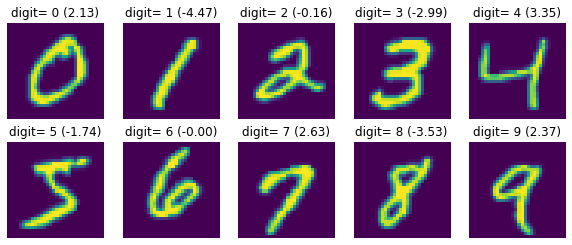

In [55]:
def pick_digits(labels):
    digits = torch.zeros((len(labels),) + ideal_digits.shape[1:])
    for i, l in enumerate(labels):
        digits[i, ...] = ideal_digits[l, ...]
    return digits

def pick_mu(labels):
    mus = torch.zeros((len(labels),) + ideal_mu.shape[1:])
    for i, l in enumerate(labels):
        mus[i, ...] = ideal_mu[l, ...]
    return mus

def plot_labels(labels):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4)); axes = axes.flatten()
    dplots = pick_digits(labels)
    mcheck = pick_mu(labels)
    for i, ax in zip(range(len(labels)), axes):
        ax.imshow(dplots[i, 0, ...])
        ax.set_title('digit= %d (%.2f)'%(labels[i], torch.sum(mcheck[i])))
    for ax in axes:
        ax.axis('off')

plot_labels(list(range(10)))

In [56]:
# build model
lfn_specs = SequentialSpec([
    LinearSpec(64, 128, ActivationFn.RELU),
    LinearSpec(128, 64, ActivationFn.NONE),
])
lode_spec = ODEBlockSpec(use_adjoint=True)
lnet = build_dyn(lfn_specs, lode_spec)

In [66]:
# train
def train_l(loader, target_mu, vae, net):
    lr, momentum = 0.01, 0.9
    net.train()
    vae.eval()
    for epoch in range(10):
        criterion = nn.MSELoss()
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
        total = len(loader)
        for batch_idx, (data, labels) in enumerate(loader):
            optimizer.zero_grad()
            pred = net(data)
            loss = criterion(pred, pick_mu(labels))
            loss.backward()
            optimizer.step()
            if batch_idx%10 == 0 or batch_idx == total-1:
                print('Epoch %3d [%4d/%4d (%2d%%)]: loss= %f'%(
                    epoch, batch_idx, total, int(100 * batch_idx / total), loss.item()))

In [67]:
train_l(mvec_loader, ideal_mu, vae_64, lnet)

Epoch   0 [   0/ 938 ( 0%)]: loss= 0.100578
Epoch   0 [  10/ 938 ( 1%)]: loss= 0.082334
Epoch   0 [  20/ 938 ( 2%)]: loss= 0.096208
Epoch   0 [  30/ 938 ( 3%)]: loss= 0.094316
Epoch   0 [  40/ 938 ( 4%)]: loss= 0.097803
Epoch   0 [  50/ 938 ( 5%)]: loss= 0.095095
Epoch   0 [  60/ 938 ( 6%)]: loss= 0.100861
Epoch   0 [  70/ 938 ( 7%)]: loss= 0.096018
Epoch   0 [  80/ 938 ( 8%)]: loss= 0.102219
Epoch   0 [  90/ 938 ( 9%)]: loss= 0.097617
Epoch   0 [ 100/ 938 (10%)]: loss= 0.103842
Epoch   0 [ 110/ 938 (11%)]: loss= 0.100684


KeyboardInterrupt: 

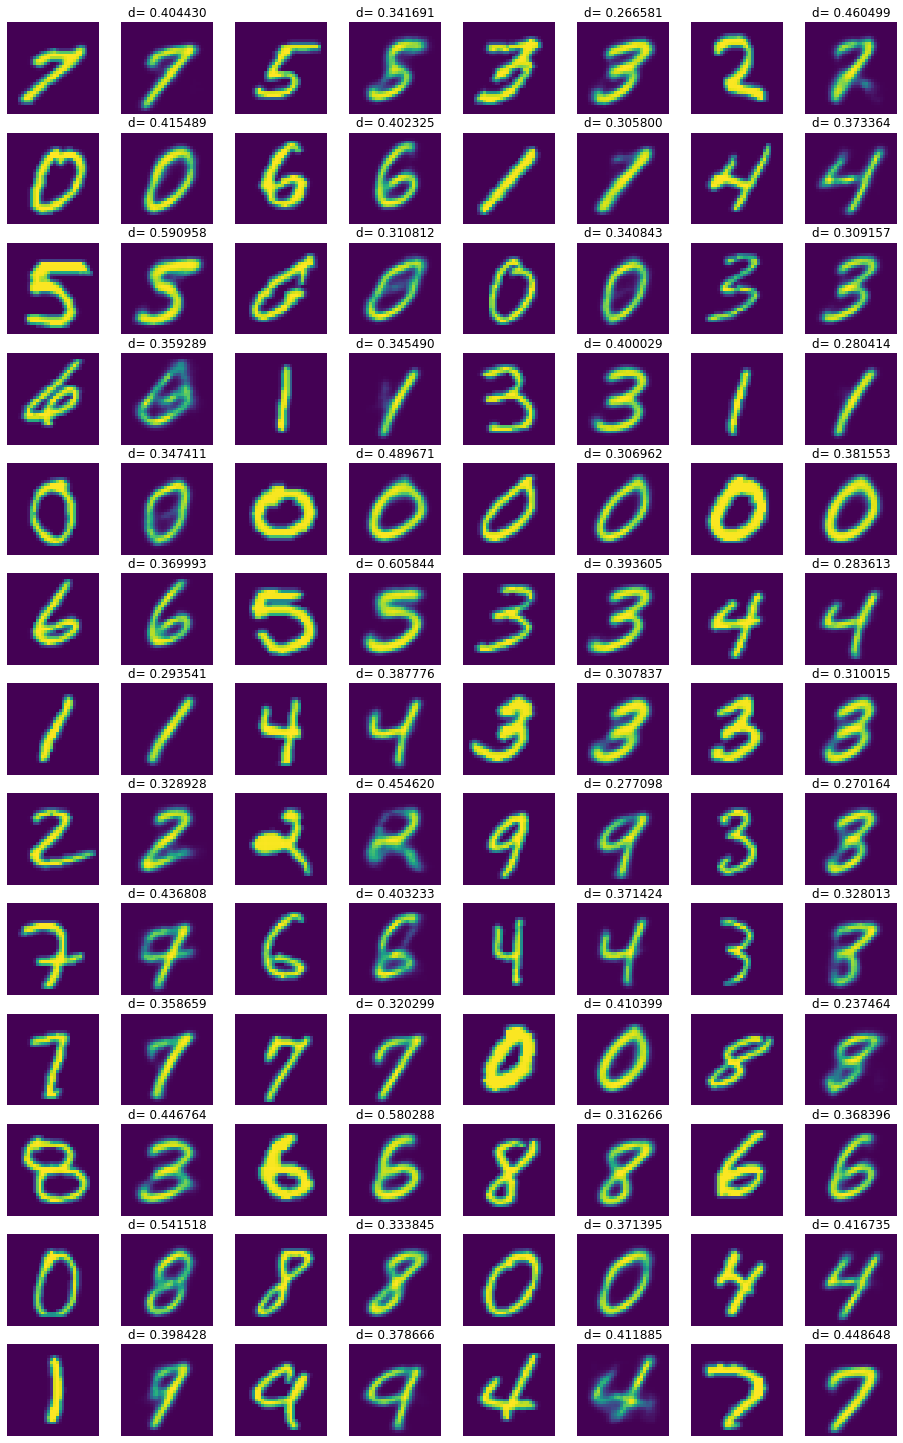

In [68]:
def plot_check_vae(NET, VAE, NX):
    with torch.no_grad():
        # generate initial point and find trajectory
        x0 = next(iter(mnist_loader))[0][:NX]
        z0, _ = VAE.nets[0](x0)
        traj = VAE.nets[1](NET(z0))

    NC, SZ = 4, 2
    NR = (NX - 1) // (2*NC) + 1
    fig, axes = plt.subplots(nrows=NR, ncols=2*NC, figsize=(2*NC*SZ, NR*SZ))
    axes = axes.flatten()
    axes0 = axes[::2]
    axes1 = axes[1::2]
    for i, ax0, ax1 in zip(range(NX), axes0, axes1):
        ax0.imshow(x0[i, 0, ...])
        ax1.imshow(traj[i, 0, ...])
        ax1.set_title('d= %f'%(torch.mean((z0[i] - ideal_mu)**2).item()))
    for ax in axes:
        ax.axis('off')
        
plot_check_vae(lnet, vae_64, 100)

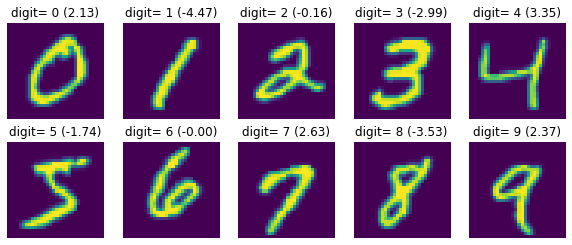

In [69]:
plot_labels(list(range(10)))

In [70]:
def plot_check_traj_vae(NET, VAE, NX, OFFSET, TR=2.0):
    with torch.no_grad():
        # generate initial point and find trajectory
        L, R, NT = 0.0, 1.0, 2
        x0 = torch.stack([mnist[OFFSET][0]])
        z0, _ = VAE.nets[0](x0)
        traj = VAE.nets[1](NET.trajectory(z0, 0.0, TR, NX)[:, 0, ...])

    NC, SZ = 8, 2
    NR = (NX - 1) // NC + 1
    fig, axes = plt.subplots(nrows=NR, ncols=NC, figsize=(NC*SZ, NR*SZ))
    axes = axes.flatten()
    for i, ax, t in zip(range(NX), axes, np.linspace(0.0, TR, NX)):
        ax.imshow(traj[i, 0, ...])
        ax.set_title('t= %f'%t)
    for ax in axes:
        ax.axis('off')

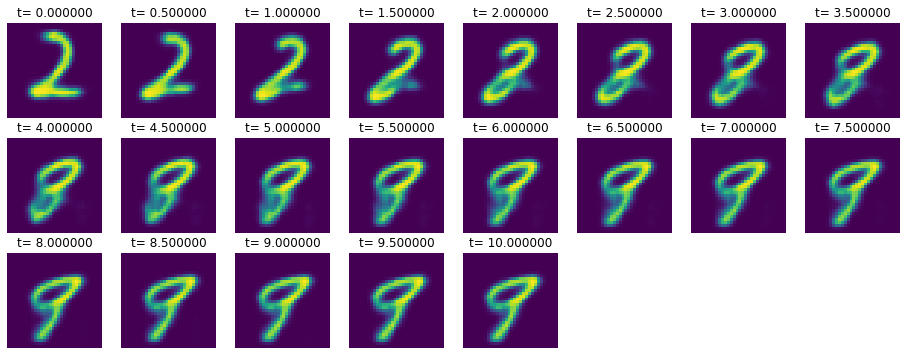

In [71]:
TR = 10
MUL = 2
plot_check_traj_vae(lnet, vae_64, TR*MUL+1, 122, TR=TR)

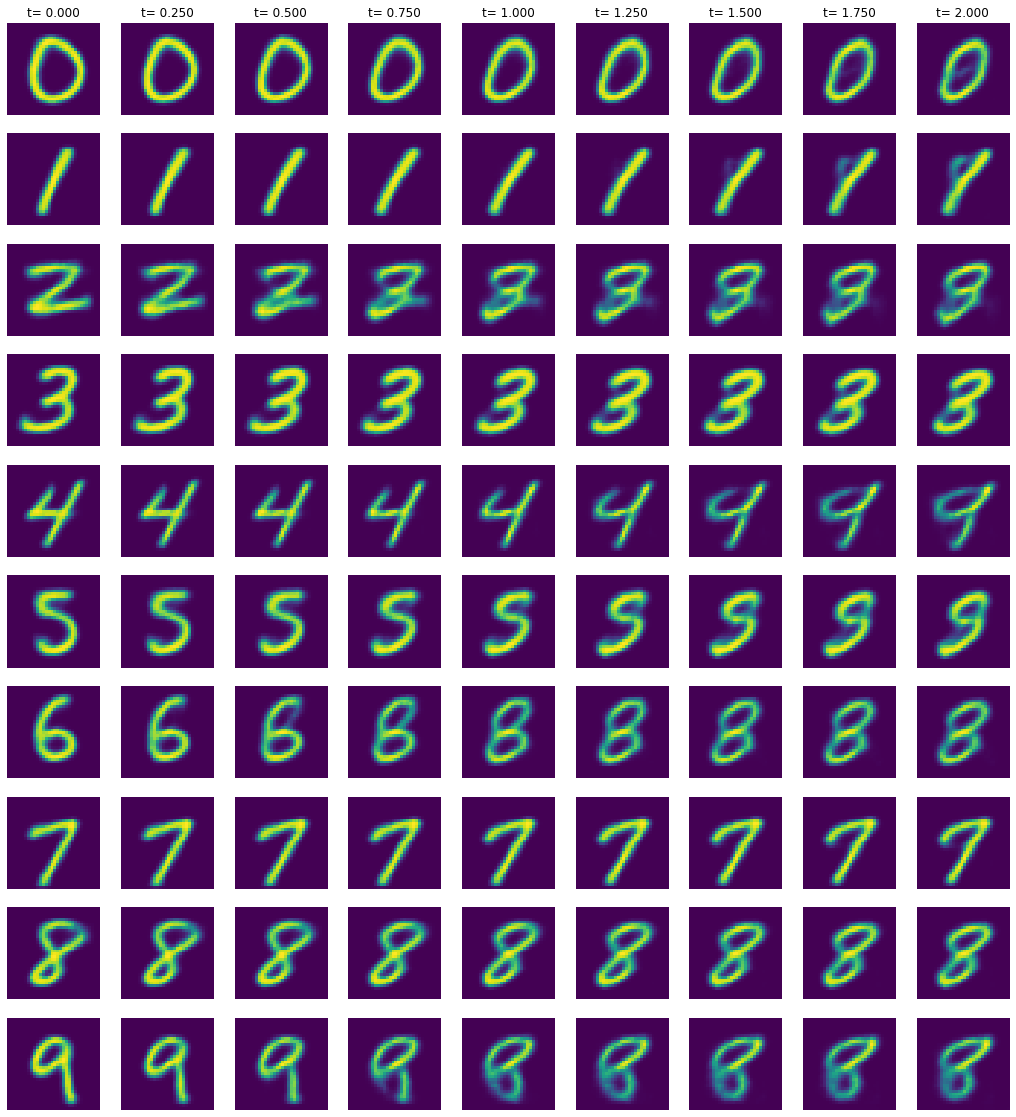

In [72]:
def plot_check_traj_vae_multiple(NET, VAE, NR, NC, TR=2.0):
    with torch.no_grad():
#         x0 = next(iter(mnist_loader))[0][:NR]
        x0 = torch.stack([dm[11][0] for dm in dmnist])
        z0, _ = VAE.nets[0](x0)
        traj = NET.trajectory(z0, 0.0, TR, NC)
        
    SZ = 2.0
    fig, axes = plt.subplots(nrows=NR, ncols=NC, figsize=(NC*SZ, NR*SZ))
    for i, axs in zip(range(NR), axes):
        img_traj = VAE.nets[1](traj[:, i, ...]).detach().numpy()
        for j, ax, t in zip(range(NC), axs, np.linspace(0.0, TR, NC)):
            ax.imshow(img_traj[j, 0, ...])
            if i == 0:
                ax.set_title('t= %.3f'%t)
    for ax in axes.flatten():
        ax.axis('off')
        
plot_check_traj_vae_multiple(lnet, vae_64, 10, 9, TR=2.0)

## MNIST Class GMM

Assume that MNIST digit classes have multiple representation in the VAE's latent space, $\mu_{c, g}$. Solve this via EM algorithm where E-step and M-step are
- E-step: Fit mixture to model's prediction
  1. Get solutions at time t=1 for each data point
  2. Find centers of clusters per labeled class
- M-step: Fit model to the mixture
  1. Assign soft probability for each pair data point and class center
  2. Minimize cross entropy from predicted density $q(c | x)$ to ground-truth $p(c | x)$

In [104]:
# build model
lgfn_specs = SequentialSpec([
    LinearSpec(64, 128, ActivationFn.RELU),
    LinearSpec(128, 64, ActivationFn.NONE),
])
lgode_spec = ODEBlockSpec(use_adjoint=True)
lgnet = build_dyn(lfn_specs, lode_spec)

In [105]:
next(iter(mvec_loader))

(tensor([[-0.0258, -0.0173, -0.0166,  ..., -0.0131, -0.0158, -0.0426],
         [ 0.0723, -0.0258, -0.0346,  ..., -0.0317, -0.0883, -0.1632],
         [-0.0245, -0.0188, -0.0021,  ...,  0.0223, -0.0125, -0.0629],
         ...,
         [-0.0147,  0.0109, -0.0237,  ...,  0.0038,  0.0081,  0.0352],
         [-0.0699, -0.0030,  0.0032,  ..., -0.0234,  0.0199, -0.0025],
         [-0.0741,  0.0600, -0.0318,  ..., -0.0036,  0.0566,  0.2056]],
        grad_fn=<AddmmBackward>),
 tensor([5, 7, 6, 5, 6, 7, 3, 2, 8, 4, 0, 4, 2, 8, 0, 6, 1, 9, 6, 3, 6, 2, 6, 5,
         1, 0, 3, 2, 5, 9, 9, 1, 9, 7, 5, 0, 1, 6, 7, 6, 1, 1, 6, 8, 7, 7, 8, 6,
         7, 1, 5, 4, 3, 3, 5, 2, 4, 1, 6, 2, 8, 8, 6, 8]))

In [109]:
def fit_gmm(loader, net, n_class, n_components, nsample=None):
    if nsample is None: nsample = len(loader)
    print('use at least %d samples'%(nsample))
    
    # get samples of solutions and their labels
    vecs = []
    cls = []
    for data, labels in loader:
        # append transformed data and label
        with torch.no_grad():
            vecs.append(net(data).numpy())
            cls.append(labels.numpy())
        
        # enough sample?
        nsample -= len(data)
        if nsample <= 0: break
    vecs = np.concatenate(vecs)
    cls = np.concatenate(cls)
        
    # fit gmm for each class
    gs = []
    for cl in range(n_class):
        g = mixture.GaussianMixture(n_components=n_components)
        gs.append(g.fit(vecs[cls == cl]))
    return gs

gs = fit_gmm(mvec_loader, lgnet, 10, 5, nsample=1000)

60000
use at least 10000 samples


In [161]:
for g in gs:
    print(g.weights_)

[0.19999227 0.21135375 0.19378851 0.19278429 0.20208118]
[0.23475307 0.23647875 0.12335687 0.20411035 0.20130096]
[0.20702362 0.16599747 0.19009065 0.18791042 0.24897785]
[0.19172673 0.21387501 0.18651337 0.19858627 0.20929862]
[0.20801352 0.12487758 0.20269877 0.26175498 0.20265515]
[0.24573154 0.19128223 0.11912823 0.22347266 0.22038534]
[0.2779139  0.15445819 0.15974685 0.23758514 0.17029591]
[0.19583779 0.25234715 0.14313727 0.16389449 0.2447833 ]
[0.17011509 0.23371918 0.2552302  0.18997683 0.1509587 ]
[0.22733837 0.16874217 0.2541275  0.1923655  0.15742647]


In [193]:
x, y = next(iter(mvec_loader))
z = lgnet(x)
D = 0
mn_dists = [[MultivariateNormal(torch.Tensor(gs[D].means_[i]), torch.Tensor(gs[D].covariances_[i])) for i in range(5)] for D in range(10)]
mn_logws = torch.Tensor([[np.log(gs[D].weights_[i]) for i in range(5)] for D in range(10)])

# for zi, yi in zip(z, y):
#     likelihoods = torch.Tensor([[mn_dists[d][k].log_prob(zi) for k in range(5)] for d in range(10)]) + mn_logws
#     posteriors = torch.logsumexp(likelihoods, dim=1) - torch.logsumexp(likelihoods, dim=(0, 1))
#     if posteriors.argmax() != yi:
#         print(posteriors, yi)
#     print(posteriors.argmax(), yi)

    
print(mn_dists[0][0].log_prob(z))
likelihoods = torch.stack([torch.stack([mn_dists[d][k].log_prob(z) for k in range(5)], dim=1) for d in range(10)], dim=1) + mn_logws[None, :, :].repeat(z.shape[0], 1, 1)
print(likelihoods.shape)
print(y)
posteriors = torch.logsumexp(likelihoods, dim=2) - torch.logsumexp(likelihoods, dim=(1, 2))[:, None].repeat(1, 10)
print(posteriors)

# posteriors = torch.logsumexp(likelihoods, dim=1) - torch.logsumexp(likelihoods, dim=(0, 1))
# if posteriors.argmax() != yi:
#     print(posteriors, yi)
# print(posteriors.argmax(), yi)

tensor([ -536.5774,  -982.5783, -2391.2092,    20.0860,    79.3201,  -933.6921,
         -480.1075,    67.3029,  -201.9892,  -489.8398,  -927.9778,  -906.2731,
          -76.7623,  -234.8460,  -364.7023,  -997.5602,  -460.4351,  -912.3771,
         -623.3291,  -406.8524,  -972.1411, -1001.6741,  -446.6171, -1065.9462,
         -833.2905, -1309.3605,  -735.7155,  -833.1557,  -815.3869,  -612.5413,
         -410.1382,  -770.1536, -1527.8274,  -734.8593,  -251.8551, -1085.7527,
         -691.4288,  -410.8640,  -333.2955, -1089.7610, -1044.9213, -1373.9166,
         -726.1414,  -595.1158,    99.9637, -1079.0548,  -196.5733,  -354.3754,
        -1163.7222, -1612.1604,  -502.0214,  -567.2590, -2244.3005, -1986.1714,
         -798.6497, -1183.4398,  -206.6564,    23.9442,  -627.7610,  -758.1172,
         -195.1436, -2028.7559,  -399.2314,  -436.0869],
       grad_fn=<SubBackward0>)
torch.Size([64, 10, 5])
tensor([2, 3, 8, 0, 0, 5, 1, 0, 0, 8, 2, 3, 6, 3, 6, 4, 3, 8, 5, 4, 8, 7, 3, 8,
        

In [177]:
a = torch.Tensor([[1, 2], [3, 4]])
print(a[:, :, None].repeat(1, 1, 10))

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]],

        [[3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
         [4., 4., 4., 4., 4., 4., 4., 4., 4., 4.]]])


In [ ]:
# train
def train_l(loader, target_mu, vae, net):
    lr, momentum = 0.01, 0.9
    net.train()
    vae.eval()
    for epoch in range(10):
        criterion = nn.MSELoss()
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
        total = len(loader)
        for batch_idx, (data, labels) in enumerate(loader):
            optimizer.zero_grad()
            enc, _ = vae.nets[0](data)
            pred = net(enc)
            loss = criterion(pred, pick_mu(labels))
            loss.backward()
            optimizer.step()
            if batch_idx%10 == 0 or batch_idx == total-1:
                print('Epoch %3d [%4d/%4d (%2d%%)]: loss= %f'%(
                    epoch, batch_idx, total, int(100 * batch_idx / total), loss.item()))